## Pairs Trading

Pairs trading is a form of *mean-reversion* h=that has a distinct advantage of always being hedged against market movements. It is generally a high alpha strategy when backed up by some rigorous statistics. The stratey is based on mathematical analysis.

The prinicple is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

In order to understand pairs trading, we need to understand three mathematical concepts: **Stationarity, Integration, and Cointegration**.

**Note:** This will assume everyone knows the basics of hypothesis testing.

In [5]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Stationarity/Non-Stationarity

Stationarity is the most commonly untestedassumption in time series analysis. We generally assume that data is stationary when the parameters of the data generating process do not change over time. Else consider two series: A and B. Series A will generate a stationary time series with fixed parameters, while B will change over time.

We will create a function that creates a z-score for probability density function. The probability density for a Gaussian distribution is:

$$ p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$$


$\mu$ is the mean and $\sigma$ is the standard deviation. The square of the standard deviation, $\sigma^{2}$, is the variance. The empircal rule dictates that 66% of the data should be somewhere between $x+\sigma$ and $x-\sigma$,which implies that the function `numpy.random.normal` is more likely to return samples lying close to the mean, rather than those far away.

In [6]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

From there, we can create two plots that exhibit a stationary and non-stationary time series.

Text(0.5,1,'Non-Stationary')

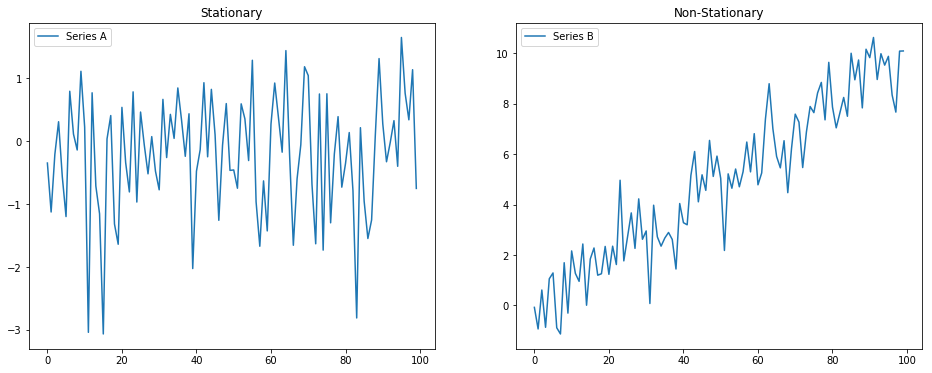

In [38]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)
    
fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')

### Why Stationarity is Important

Many statistical test require that the data being tested are stationary. Using certain statistics on a non-stationary data set may lead to garbage results. As an example, let's take an average through our non-stationary $B$.

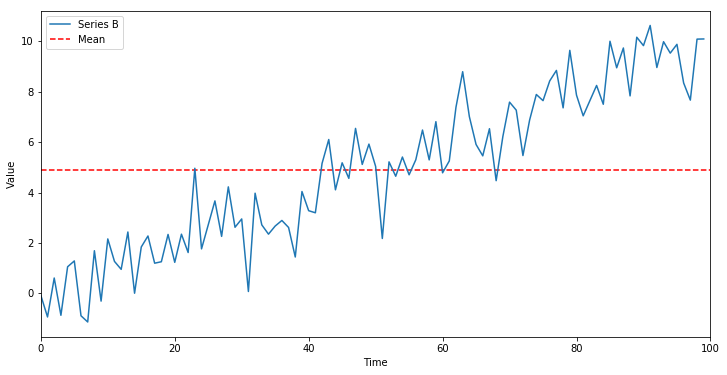

In [43]:
mean = np.mean(B)

plt.figure(figsize=(12,6))
plt.plot(B)
plt.hlines(mean, 0, len(B), linestyles='dashed', colors = 'r')
plt.xlabel('Time')
plt.xlim([0, 100])
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

The computed mean will show that the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specific time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can distort the analysis, much more subtle problems can arise in practice.

#### Augmented Dickey Fuller

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root tet because under the null hypothesis, the autoregressive polynominal of $\scr{z}_{t},\ \phi (\scr{z})=\ (1-\phi \scr{z}) \ = 0$, has a root equal to unity. 

$y_{t}$ is trend stationary under the null hypothesis. If $y_{t}$is then first differenced, it becomes:

$$
\begin{aligned}
\Delta y_{t} & = \delta\ + \Delta\scr{z}_{t} \\
\Delta \scr_{z} & = \phi\Delta\scr{z}_{t-1}\ +\ \varepsilon_{t}\ -\ \varepsilon_{t-1} \\
\end{aligned}
.$$

The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$

$\hat{\phi}$ is the least square estimate and SE($\hat{\phi}$) is the usual standard error estimate. The test is a one-sided left tail test. If {$y_{t}$} is stationary, then it can be shown that

$$\sqrt{T}(\hat{\phi}-\phi)\xrightarrow[\text{}]{\text{d}}N(0,(1-\phi^{2}))$$

or 

$$\hat{\phi}\overset{\text{A}}{\sim}N\bigg(\phi,\frac{1}{T}(1-\phi^{2}) \bigg)$$

andit follows that $t_{\phi=1}\overset{\text{A}}{\sim}N(0,1).$ However, under the null hypothesis of non-stationarity, the above result gives

$$
\hat{\phi}\overset{\text{A}}{\sim} N(0,1)
$$

The following function will allow us to check for stationarity using the Augmented Dickey Fuller (ADF) test.

In [50]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [51]:
stationarity_test(A)
stationarity_test(B)

p-value = 4.0811223061569216e-17 The series A is likely stationary.
p-value = 0.7317208279589542 The series B is likely non-stationary.


As we can see, based on the test statistic (which correspnds with a specific p-value) for time series A, we can fail to reject the null hypothesis. As such, Series A is likely to be  stationary. On the other hand, Series B is rejected by the hypothesis test, so this time series is likely to be non-stationary.